In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from src.models.frontier import MultiStockEnv, Agent, backtest, maybe_make_dir
from src.config import market_tickers
from src.config.model_config import model_parameters

CPU times: user 5.92 s, sys: 4.42 s, total: 10.3 s
Wall time: 2.71 s


In [2]:
# papermill parameters
SEED_LIST = [
             0,
             #1111,
             #2222, 
             #3333, 
             #4444, 
             #5555,
             #6666,
             #7777,
             #8888,
             #9999
            ]

#TICKERS = market_tickers.DOW_30_TICKER
TICKERS = ['AAPL', 'AMD', 'CSCO', 'F', 'INTC']
MARKET_NAME = 'TEST_5'
MODEL_BASE_NAME = 'RL_CNN' # use either | 'RL_CNN' | 'RL_str_fcast' | 'RL_all_inp' |
FROM = '2019-01-01' # start of backtest
UNTIL = '2020-01-01' # end of backtest
NB_EPISODES = 200 # backtest model that was trained for this number of episodes

# investor preferences
GAMMA_TRADES = [0.1, 1, 10, 100]
GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
GAMMA_HOLDS = [0.1, 1]

In [3]:
# Parameters
SEED_LIST = [0]
TICKERS = [
    "AAPL",
    "MSFT",
    "JPM",
    "V",
    "RTX",
    "PG",
    "GS",
    "NKE",
    "DIS",
    "AXP",
    "HD",
    "INTC",
    "WMT",
    "IBM",
    "MRK",
    "UNH",
    "KO",
    "CAT",
    "TRV",
    "JNJ",
    "CVX",
    "MCD",
    "VZ",
    "CSCO",
    "XOM",
    "BA",
    "MMM",
    "PFE",
    "WBA",
    "DD",
]
MARKET_NAME = "DOW_30"
MODEL_BASE_NAME = "RL_CNN"
FROM = "2018-01-01"
UNTIL = "2020-01-01"
NB_EPISODES = 200
GAMMA_TRADES = [7, 8, 9, 10, 11, 12]
GAMMA_RISKS = [1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
GAMMA_HOLDS = [0.1, 1, 10, 100, 1000]


In [4]:
#------ small test-sweep ------#
# GAMMA_TRADES = [0.1, 1, 10, 100]
# GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
# GAMMA_HOLDS = [0.1, 1]
#------ extended-boyd-sweep ------#
# GAMMA_TRADES =  [0.1, 0.5, 1, 2, 3, 4, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 11, 12, 15, 20, 30, 45, 60, 100, 200]
# GAMMA_RISKS = [0.1, 0.178, 0.316, 0.562, 1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000, 2000, 5000, 10000, 20000]
#---------------------------------#

GAMMA_TRIOS = []
for tr in GAMMA_TRADES:
    for ri in GAMMA_RISKS:
        for hd in GAMMA_HOLDS:
            GAMMA_TRIOS.append((tr, ri, hd))
        
#format: (gamma_trade, gamma_risk, gamma_hold)
print('number of trios: ', len(GAMMA_TRIOS))
#GAMMA_TRIOS

number of trios:  390


In [5]:
# other constants and parameters
TICKERS.sort()
FILE_PERIOD = '1d' # weekly='5d', daily='1d'
HALF_SPREAD = 0.0005/2.0 # 'a' in transaction cost function
NONLIN_COEFF = 1.0 # 'b' transaction cost function
POWER = 1.5 # power for change in poertfolio vector used in transaction cost
INIT_PORTFOLIO = 100000000.0 # initial portfolio value

USE_FORECASTS = model_parameters[MODEL_BASE_NAME]['use_forecasts'] # whether to use forecasts as inputs to agent policy net or not
NB_FORECASTS = model_parameters[MODEL_BASE_NAME]['nb_forecasts'] # number of forecasts to use in state. Set to None for no forecasts
FORECAST_TYPE = model_parameters[MODEL_BASE_NAME]['forecast_type'] # use 'strong' or 'weak' forecasts (if no forecasts given, this does not matter)
USE_CNN_STATE = model_parameters[MODEL_BASE_NAME]['use_cnn_state'] # whether to pass log-rets block for CNN part of policy net (set to false for forecast only)

TEST_NAME = f'{MARKET_NAME}_{MODEL_BASE_NAME}_seeds_{SEED_LIST[0]}_etc'
RESULTS_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/backtests/'
DATA_DIR = f'../data/{MARKET_NAME}/preprocessed_data/'

## create agent(s) and backtest in new backtest env

In [6]:
%%time
# make directory for results if it does not exist already
maybe_make_dir(RESULTS_DIR)

print('creating environment and agent...')
env = MultiStockEnv(tickers=TICKERS, 
                    from_date=FROM,
                    until=UNTIL, 
                    #nb_episodes=100,
                    cash_key='USDOLLAR', 
                    #gamma_risk=GAMMA_RISK, 
                    #gamma_trade=GAMMA_TRADE,
                    #half_spread=HALF_SPREAD, 
                    nonlin_coef=NONLIN_COEFF, 
                    power=POWER, 
                    datadir=DATA_DIR, 
                    state_lookback_window=20, 
                    #distribution=EPISODE_DRAW_DISTRIBUTION,
                    #days_duration=DAYS_IN_EPISODE, 
                    mode='backtest', 
                    random_seed=7,
                    init_portfolio=INIT_PORTFOLIO, 
                    period_in_file_name=FILE_PERIOD, 
                    nb_forecasts=NB_FORECASTS, 
                    forecast_type=FORECAST_TYPE,
                    use_CNN_state=USE_CNN_STATE,
                    verbose=False)

agent = Agent(alpha=0.001, 
              gamma=0.99, 
              n_assets=len(TICKERS)+1, 
              tau=5, 
              lookback_window=20, 
              n_feature_maps=len(TICKERS)+1,
              use_forecasts=USE_FORECASTS,
              use_CNN_state=USE_CNN_STATE,
              allow_long_short_trades=True)

results_dict = {}
#actions_dict = {}
print('backtesting:')

total_backtests = len(SEED_LIST) * len(GAMMA_TRIOS)
backtest_counter = 0

for RANDOM_SEED in SEED_LIST:
    for (GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD) in GAMMA_TRIOS:
        
        backtest_counter += 1
        print(f'\t[{backtest_counter}/{total_backtests}]\t{MODEL_BASE_NAME}: gamma_trade={GAMMA_TRADE}, gamma_risk={GAMMA_RISK}, gamma_hold={GAMMA_HOLD}, seed={RANDOM_SEED}...')
        
        # load trained RL model for backtesting
        SAVED_MODEL_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}/models/{MODEL_BASE_NAME}_seed_{RANDOM_SEED}_{NB_EPISODES}'
        # set dir where actions csv file will be saved
        actions_dir = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}'
        
        try:
            rl_rets, rl_actions = backtest(agent, env, weights_file_dir=SAVED_MODEL_DIR, verbose=False)
            
            #rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[1:].index)
            #rl_actions = pd.DataFrame(data=rl_actions, index=env.returns.loc[FROM:UNTIL].iloc[0:].index, columns=TICKERS+['USDOLLAR'])
            rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[:-1].index)
            rl_rets = rl_rets.shift(1)
            rl_rets.iloc[0] = 0
            rl_actions = pd.DataFrame(data=rl_actions[:-1], index=env.returns.loc[FROM:UNTIL].iloc[:-1].index, columns=TICKERS+['USDOLLAR'])
            
            # save actions
            rl_actions.to_csv(f'{actions_dir}/actions.csv')
            #print('actions saved.')

            cash_rets = env.returns.loc[FROM:UNTIL, env.cash_key].iloc[:-1]
            excess_rets = rl_rets - cash_rets

            R_e = excess_rets.mean() * 100 * 252
            sigma_e = excess_rets.std() * 100 * np.sqrt(252)
            sharpe = R_e / sigma_e

            results_dict[(GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD, RANDOM_SEED)] = {'excess_return':R_e, 'excess_risk':sigma_e, 'sharpe':sharpe}
        except Exception as e:
            print(f'**error for model: trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}')
            #print(e)

creating environment and agent...


backtesting:
	[1/390]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=0.1, seed=0...


	[2/390]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=1, seed=0...


	[3/390]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=10, seed=0...


	[4/390]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=100, seed=0...


	[5/390]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=1000, seed=0...


	[6/390]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=0.1, seed=0...


	[7/390]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=1, seed=0...


	[8/390]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=10, seed=0...


	[9/390]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=100, seed=0...


	[10/390]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=1000, seed=0...


	[11/390]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=0.1, seed=0...


	[12/390]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=1, seed=0...


	[13/390]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=10, seed=0...


	[14/390]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=100, seed=0...


	[15/390]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=1000, seed=0...


	[16/390]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=0.1, seed=0...


	[17/390]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=1, seed=0...


	[18/390]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=10, seed=0...


	[19/390]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=100, seed=0...


	[20/390]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=1000, seed=0...


	[21/390]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=0.1, seed=0...


	[22/390]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=1, seed=0...


	[23/390]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=10, seed=0...


	[24/390]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=100, seed=0...


	[25/390]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=1000, seed=0...


	[26/390]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=0.1, seed=0...


	[27/390]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=1, seed=0...


	[28/390]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=10, seed=0...


	[29/390]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=100, seed=0...


	[30/390]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=1000, seed=0...


	[31/390]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=0.1, seed=0...


	[32/390]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=1, seed=0...


	[33/390]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=10, seed=0...


	[34/390]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=100, seed=0...


	[35/390]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=1000, seed=0...


	[36/390]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=0.1, seed=0...


	[37/390]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=1, seed=0...


	[38/390]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=10, seed=0...


	[39/390]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=100, seed=0...


	[40/390]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=1000, seed=0...


	[41/390]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=0.1, seed=0...


	[42/390]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=1, seed=0...


	[43/390]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=10, seed=0...


	[44/390]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=100, seed=0...


	[45/390]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=1000, seed=0...


	[46/390]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=0.1, seed=0...


	[47/390]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=1, seed=0...


	[48/390]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=10, seed=0...


	[49/390]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=100, seed=0...


	[50/390]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=1000, seed=0...


	[51/390]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=0.1, seed=0...


	[52/390]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=1, seed=0...


	[53/390]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=10, seed=0...


	[54/390]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=100, seed=0...


	[55/390]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=1000, seed=0...


	[56/390]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=0.1, seed=0...


	[57/390]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=1, seed=0...


	[58/390]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=10, seed=0...


	[59/390]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=100, seed=0...


	[60/390]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=1000, seed=0...


	[61/390]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[62/390]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=1, seed=0...


	[63/390]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=10, seed=0...


	[64/390]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=100, seed=0...


	[65/390]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=1000, seed=0...


	[66/390]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=0.1, seed=0...


	[67/390]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=1, seed=0...


	[68/390]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=10, seed=0...


	[69/390]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=100, seed=0...


	[70/390]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=1000, seed=0...


	[71/390]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=0.1, seed=0...


	[72/390]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=1, seed=0...


	[73/390]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=10, seed=0...


	[74/390]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=100, seed=0...


	[75/390]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=1000, seed=0...


	[76/390]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=0.1, seed=0...


	[77/390]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=1, seed=0...


	[78/390]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=10, seed=0...


	[79/390]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=100, seed=0...


	[80/390]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=1000, seed=0...


	[81/390]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=0.1, seed=0...


	[82/390]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=1, seed=0...


	[83/390]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=10, seed=0...


	[84/390]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=100, seed=0...


	[85/390]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=1000, seed=0...


	[86/390]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=0.1, seed=0...


	[87/390]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=1, seed=0...


	[88/390]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=10, seed=0...


	[89/390]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=100, seed=0...


	[90/390]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=1000, seed=0...


	[91/390]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=0.1, seed=0...


	[92/390]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=1, seed=0...


	[93/390]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=10, seed=0...


	[94/390]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=100, seed=0...


	[95/390]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=1000, seed=0...


	[96/390]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=0.1, seed=0...


	[97/390]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=1, seed=0...


	[98/390]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=10, seed=0...


	[99/390]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=100, seed=0...


	[100/390]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=1000, seed=0...


	[101/390]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=0.1, seed=0...


	[102/390]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=1, seed=0...


	[103/390]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=10, seed=0...


	[104/390]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=100, seed=0...


	[105/390]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=1000, seed=0...


	[106/390]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=0.1, seed=0...


	[107/390]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=1, seed=0...


	[108/390]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=10, seed=0...


	[109/390]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=100, seed=0...


	[110/390]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=1000, seed=0...


	[111/390]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=0.1, seed=0...


	[112/390]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=1, seed=0...


	[113/390]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=10, seed=0...


	[114/390]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=100, seed=0...


	[115/390]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=1000, seed=0...


	[116/390]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=0.1, seed=0...


	[117/390]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=1, seed=0...


	[118/390]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=10, seed=0...


	[119/390]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=100, seed=0...


	[120/390]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=1000, seed=0...


	[121/390]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=0.1, seed=0...


	[122/390]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=1, seed=0...


	[123/390]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=10, seed=0...


	[124/390]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=100, seed=0...


	[125/390]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=1000, seed=0...


	[126/390]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[127/390]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=1, seed=0...


	[128/390]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=10, seed=0...


	[129/390]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=100, seed=0...


	[130/390]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=1000, seed=0...


	[131/390]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=0.1, seed=0...


	[132/390]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=1, seed=0...


	[133/390]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=10, seed=0...


	[134/390]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=100, seed=0...


	[135/390]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=1000, seed=0...


	[136/390]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=0.1, seed=0...


	[137/390]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=1, seed=0...


	[138/390]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=10, seed=0...


	[139/390]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=100, seed=0...


	[140/390]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=1000, seed=0...


	[141/390]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=0.1, seed=0...


	[142/390]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=1, seed=0...


	[143/390]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=10, seed=0...


	[144/390]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=100, seed=0...


	[145/390]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=1000, seed=0...


	[146/390]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=0.1, seed=0...


	[147/390]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=1, seed=0...


	[148/390]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=10, seed=0...


	[149/390]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=100, seed=0...


	[150/390]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=1000, seed=0...


	[151/390]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=0.1, seed=0...


	[152/390]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=1, seed=0...


	[153/390]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=10, seed=0...


	[154/390]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=100, seed=0...


	[155/390]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=1000, seed=0...


	[156/390]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=0.1, seed=0...


	[157/390]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=1, seed=0...


	[158/390]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=10, seed=0...


	[159/390]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=100, seed=0...


	[160/390]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=1000, seed=0...


	[161/390]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=0.1, seed=0...


	[162/390]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=1, seed=0...


	[163/390]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=10, seed=0...


	[164/390]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=100, seed=0...


	[165/390]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=1000, seed=0...


	[166/390]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=0.1, seed=0...


	[167/390]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=1, seed=0...


	[168/390]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=10, seed=0...


	[169/390]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=100, seed=0...


	[170/390]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=1000, seed=0...


	[171/390]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=0.1, seed=0...


	[172/390]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=1, seed=0...


	[173/390]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=10, seed=0...


	[174/390]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=100, seed=0...


	[175/390]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=1000, seed=0...


	[176/390]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=0.1, seed=0...


	[177/390]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=1, seed=0...


	[178/390]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=10, seed=0...


	[179/390]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=100, seed=0...


	[180/390]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=1000, seed=0...


	[181/390]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=0.1, seed=0...


	[182/390]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=1, seed=0...


	[183/390]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=10, seed=0...


	[184/390]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=100, seed=0...


	[185/390]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=1000, seed=0...


	[186/390]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=0.1, seed=0...


	[187/390]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=1, seed=0...


	[188/390]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=10, seed=0...


	[189/390]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=100, seed=0...


	[190/390]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=1000, seed=0...


	[191/390]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[192/390]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=1, seed=0...


	[193/390]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=10, seed=0...


	[194/390]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=100, seed=0...


	[195/390]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=1000, seed=0...


	[196/390]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=0.1, seed=0...


	[197/390]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=1, seed=0...


	[198/390]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=10, seed=0...


	[199/390]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=100, seed=0...


	[200/390]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=1000, seed=0...


	[201/390]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=0.1, seed=0...


	[202/390]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=1, seed=0...


	[203/390]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=10, seed=0...


	[204/390]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=100, seed=0...


	[205/390]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=1000, seed=0...


	[206/390]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=0.1, seed=0...


	[207/390]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=1, seed=0...


	[208/390]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=10, seed=0...


	[209/390]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=100, seed=0...


	[210/390]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=1000, seed=0...


	[211/390]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=0.1, seed=0...


	[212/390]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=1, seed=0...


	[213/390]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=10, seed=0...


	[214/390]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=100, seed=0...


	[215/390]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=1000, seed=0...


	[216/390]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=0.1, seed=0...


	[217/390]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=1, seed=0...


	[218/390]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=10, seed=0...


	[219/390]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=100, seed=0...


	[220/390]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=1000, seed=0...


	[221/390]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=0.1, seed=0...


	[222/390]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=1, seed=0...


	[223/390]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=10, seed=0...


	[224/390]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=100, seed=0...


	[225/390]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=1000, seed=0...


	[226/390]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=0.1, seed=0...


	[227/390]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=1, seed=0...


	[228/390]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=10, seed=0...


	[229/390]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=100, seed=0...


	[230/390]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=1000, seed=0...


	[231/390]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=0.1, seed=0...


	[232/390]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=1, seed=0...


	[233/390]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=10, seed=0...


	[234/390]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=100, seed=0...


	[235/390]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=1000, seed=0...


	[236/390]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=0.1, seed=0...


	[237/390]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=1, seed=0...


	[238/390]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=10, seed=0...


	[239/390]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=100, seed=0...


	[240/390]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=1000, seed=0...


	[241/390]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=0.1, seed=0...


	[242/390]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=1, seed=0...


	[243/390]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=10, seed=0...


	[244/390]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=100, seed=0...


	[245/390]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=1000, seed=0...


	[246/390]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=0.1, seed=0...


	[247/390]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=1, seed=0...


	[248/390]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=10, seed=0...


	[249/390]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=100, seed=0...


	[250/390]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=1000, seed=0...


	[251/390]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=0.1, seed=0...


	[252/390]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=1, seed=0...


	[253/390]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=10, seed=0...


	[254/390]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=100, seed=0...


	[255/390]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=1000, seed=0...


	[256/390]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[257/390]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=1, seed=0...


	[258/390]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=10, seed=0...


	[259/390]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=100, seed=0...


	[260/390]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=1000, seed=0...


	[261/390]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=0.1, seed=0...


	[262/390]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=1, seed=0...


	[263/390]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=10, seed=0...


	[264/390]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=100, seed=0...


	[265/390]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=1000, seed=0...


	[266/390]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=0.1, seed=0...


	[267/390]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=1, seed=0...


	[268/390]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=10, seed=0...


	[269/390]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=100, seed=0...


	[270/390]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=1000, seed=0...


	[271/390]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=0.1, seed=0...


	[272/390]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=1, seed=0...


	[273/390]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=10, seed=0...


	[274/390]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=100, seed=0...


	[275/390]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=1000, seed=0...


	[276/390]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=0.1, seed=0...


	[277/390]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=1, seed=0...


	[278/390]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=10, seed=0...


	[279/390]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=100, seed=0...


	[280/390]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=1000, seed=0...


	[281/390]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=0.1, seed=0...


	[282/390]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=1, seed=0...


	[283/390]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=10, seed=0...


	[284/390]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=100, seed=0...


	[285/390]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=1000, seed=0...


	[286/390]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=0.1, seed=0...


	[287/390]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=1, seed=0...


	[288/390]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=10, seed=0...


	[289/390]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=100, seed=0...


	[290/390]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=1000, seed=0...


	[291/390]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=0.1, seed=0...


	[292/390]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=1, seed=0...


	[293/390]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=10, seed=0...


	[294/390]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=100, seed=0...


	[295/390]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=1000, seed=0...


	[296/390]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=0.1, seed=0...


	[297/390]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=1, seed=0...


	[298/390]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=10, seed=0...


	[299/390]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=100, seed=0...


	[300/390]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=1000, seed=0...


	[301/390]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=0.1, seed=0...


	[302/390]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=1, seed=0...


	[303/390]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=10, seed=0...


	[304/390]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=100, seed=0...


	[305/390]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=1000, seed=0...


	[306/390]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=0.1, seed=0...


	[307/390]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=1, seed=0...


	[308/390]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=10, seed=0...


	[309/390]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=100, seed=0...


	[310/390]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=1000, seed=0...


	[311/390]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=0.1, seed=0...


	[312/390]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=1, seed=0...


	[313/390]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=10, seed=0...


	[314/390]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=100, seed=0...


	[315/390]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=1000, seed=0...


	[316/390]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=0.1, seed=0...


	[317/390]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=1, seed=0...


	[318/390]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=10, seed=0...


	[319/390]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=100, seed=0...


	[320/390]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=1000, seed=0...


	[321/390]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[322/390]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=1, seed=0...


	[323/390]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=10, seed=0...


	[324/390]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=100, seed=0...


	[325/390]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=1000, seed=0...


	[326/390]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=0.1, seed=0...


	[327/390]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=1, seed=0...


	[328/390]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=10, seed=0...


	[329/390]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=100, seed=0...


	[330/390]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=1000, seed=0...


	[331/390]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=0.1, seed=0...


	[332/390]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=1, seed=0...


	[333/390]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=10, seed=0...


	[334/390]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=100, seed=0...


	[335/390]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=1000, seed=0...


	[336/390]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=0.1, seed=0...


	[337/390]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=1, seed=0...


	[338/390]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=10, seed=0...


	[339/390]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=100, seed=0...


	[340/390]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=1000, seed=0...


	[341/390]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=0.1, seed=0...


	[342/390]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=1, seed=0...


	[343/390]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=10, seed=0...


	[344/390]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=100, seed=0...


	[345/390]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=1000, seed=0...


	[346/390]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=0.1, seed=0...


	[347/390]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=1, seed=0...


	[348/390]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=10, seed=0...


	[349/390]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=100, seed=0...


	[350/390]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=1000, seed=0...


	[351/390]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=0.1, seed=0...


	[352/390]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=1, seed=0...


	[353/390]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=10, seed=0...


	[354/390]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=100, seed=0...


	[355/390]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=1000, seed=0...


	[356/390]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=0.1, seed=0...


	[357/390]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=1, seed=0...


	[358/390]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=10, seed=0...


	[359/390]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=100, seed=0...


	[360/390]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=1000, seed=0...


	[361/390]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=0.1, seed=0...


	[362/390]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=1, seed=0...


	[363/390]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=10, seed=0...


	[364/390]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=100, seed=0...


	[365/390]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=1000, seed=0...


	[366/390]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=0.1, seed=0...


	[367/390]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=1, seed=0...


	[368/390]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=10, seed=0...


	[369/390]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=100, seed=0...


	[370/390]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=1000, seed=0...


	[371/390]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=0.1, seed=0...


	[372/390]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=1, seed=0...


	[373/390]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=10, seed=0...


	[374/390]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=100, seed=0...


	[375/390]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=1000, seed=0...


	[376/390]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=0.1, seed=0...


	[377/390]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=1, seed=0...


	[378/390]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=10, seed=0...


	[379/390]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=100, seed=0...


	[380/390]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=1000, seed=0...


	[381/390]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=0.1, seed=0...


	[382/390]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=1, seed=0...


	[383/390]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=10, seed=0...


	[384/390]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=100, seed=0...


	[385/390]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=1000, seed=0...


	[386/390]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[387/390]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=1, seed=0...


	[388/390]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=10, seed=0...


	[389/390]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=100, seed=0...


	[390/390]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=1000, seed=0...


CPU times: user 1h 15min 17s, sys: 2.73 s, total: 1h 15min 20s
Wall time: 1h 15min 19s


In [7]:
results_df = pd.DataFrame(results_dict).T.reset_index()
results_df.columns = ['gamma_trade', 'gamma_risk', 'gamma_hold', 'seed', 'excess_return', 'excess_risk', 'sharpe']
results_df.to_csv(RESULTS_DIR+TEST_NAME+'.csv', index=False)
print('saved.')
results_df

saved.


,gamma_trade,gamma_risk,gamma_hold,seed,excess_return,excess_risk,sharpe
0,7,1,0.1,0,16.172078,37.535832,0.430844
1,7,1,1.0,0,13.809701,20.536371,0.672451
2,7,1,10.0,0,11.739239,16.091739,0.729520
3,7,1,100.0,0,10.715864,15.392510,0.696174
4,7,1,1000.0,0,10.153827,15.020474,0.675999
...,...,...,...,...,...,...,...
385,12,1000,0.1,0,4.184158,11.653387,0.359051
386,12,1000,1.0,0,2.096756,11.415410,0.183678
387,12,1000,10.0,0,4.145771,11.625526,0.356609
388,12,1000,100.0,0,5.085199,11.772203,0.431967


(-10.0, 70.0)

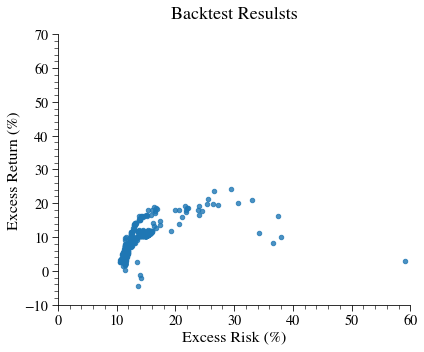

In [8]:
# risk-return plot 
results_df[['excess_return', 'excess_risk']]\
    .rename(
        columns={
            'excess_return':'Excess Return (%)', 
            'excess_risk':'Excess Risk (%)'
        })\
    .plot(
        kind='scatter', 
        x='Excess Risk (%)', 
        y='Excess Return (%)', 
        title='Backtest Resulsts', 
        alpha=0.8,
        figsize=(6,5),
        c='C0')

# x and y axis limits
plt.xlim(left=0.0, right=60.0)
plt.ylim(bottom=-10.0, top=70.0)

In [9]:
print(f'done backtesting for {MODEL_BASE_NAME}.')

done backtesting for RL_CNN.


In [10]:
agent.policy